# Goal: Characterize the behaviour of one oscillator

The parameters of a general oscillator:
1. amplitude 
2. frequency
3. phase

---

Free parameters in a leaky integrate and fire neuron:
1. refractory period (t_ref)- affects frequency
2. threshold voltage (v_th)- affects amplitude
3. voltage time constant (tau_mem)- affects frequency
4. external bias voltage (V_0)- affects frequency

(multiple controls for frequency- keep two constant and alter the third one)

---

Choice of above parameters:
1. v_th=1 (fixed amplitude oscillations)
2. t_ref = 5ms
3. tau_mem = 20ms
4. V_0 -> varied for desirable frequency

In [1]:
import numpy as np, matplotlib.pyplot as plt
import math, time
from snn.components.neuron_class import Neuron
from snn.components.synapse_class import Synapse
from snn.components.network_class import *
from snn.functions import *

In [2]:
n = Neuron('n')
net = Network('net')
net.add_neuron(n)

In [3]:
dt = 1e-3
T = 1000
V0 = 1.5
probe = net.initialize(probe=True, T_total=T)
v_ext = V0*np.ones((1, T))

In [4]:
tic = time.time()
for ti in range(T):
    net.update_state(dt, v_ext[:,ti].reshape((-1,1)), probe, ti)
print(f"time taken for {T} timesteps: {time.time()-tic}")

time taken for 1000 timesteps: 0.04687833786010742


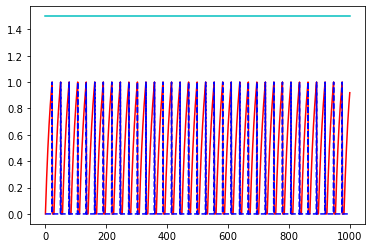

In [5]:
plt.plot(v_ext[0,:], 'c')
plt.plot(probe['v'][n.id, :], 'r')
plt.plot(probe['spike'][n.id, :], 'b--')

In [6]:
def freq(spk_train, dt, get_avg = False):
    t_spike = dt*np.argwhere(spk_train).reshape((-1,))
    if len(t_spike)<2:
        return 0
    else:
        isi =  np.array([t_spike[i+1]-t_spike[i] for i in range(len(t_spike)-1)])
        f = (1/isi)

        if get_avg:
            return np.mean(f)
    return f

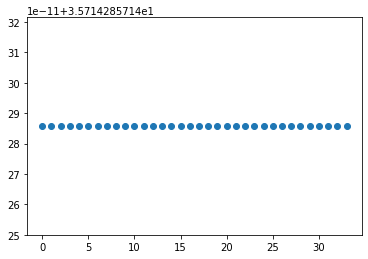

In [7]:
plt.plot(freq(probe['spike'][n.id, :], dt), 'o')

In [8]:
V0_val = np.arange(0, 20, 0.2)

In [9]:
freq_val = np.zeros(len(V0_val))

In [10]:
dt = 1e-3
T = 1000
tic = time.time()
for i in range(len(V0_val)):
    V0 = V0_val[i]
    n = Neuron('n')
    net = Network('net')
    net.add_neuron(n)
    probe = net.initialize(probe=True, T_total=T)
    v_ext = V0*np.ones((1, T))
    for ti in range(T):
        net.update_state(dt, v_ext[:,ti].reshape((-1,1)), probe, ti)
    freq_val[i] = freq(probe['spike'][n.id, :], dt, get_avg=True)
print(f"time taken for {len(V0_val)} iterations: {time.time()-tic}s")

time taken for 100 iterations: 2.9081227779388428s


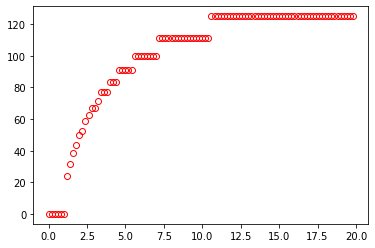

In [11]:
plt.plot(V0_val, freq_val, 'ro', markerfacecolor='none')

Text(0.5, 1.0, 'frequency of oscillation vs input')

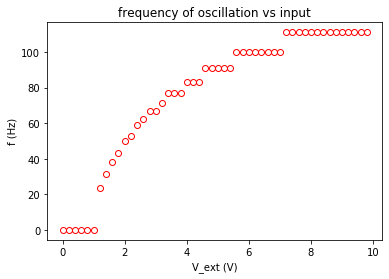

In [12]:
plt.plot(V0_val[:50], freq_val[:50], 'ro', markerfacecolor='none')
plt.xlabel('V_ext (V)')
plt.ylabel('f (Hz)')
plt.title('frequency of oscillation vs input')

Goal: Now try to understand various features of the above plot

1. jump at Vext=1 (threshold) - due to tau_m
2. piecewise constant at higher values of V_ext - due to dt
3. Saturation of f at very large V_ext- due to t_ref

# Obtain f_jump for various tau_m

In [14]:
# effect of tau_m
dt = 1e-3
taum_val = dt*np.linspace(5, 50, 10)
V0_val = np.arange(0, 20, 0.2)
freq_val = np.zeros((len(V0_val), len(taum_val)))

T = 1000
tic = time.time()

for j in range(len(taum_val)):
    tau_m = taum_val[j]
    
    for i in range(len(V0_val)):
        V0 = V0_val[i]
        n = Neuron('n', tau_mem=tau_m)
        net = Network('net')
        net.add_neuron(n)
        probe = net.initialize(probe=True, T_total=T)
        v_ext = V0*np.ones((1, T))
        for ti in range(T):
            net.update_state(dt, v_ext[:,ti].reshape((-1,1)), probe, ti)
        freq_val[i, j] = freq(probe['spike'][n.id, :], dt, get_avg=True)
print(f"time taken for {len(V0_val)*len(taum_val)} iterations: {time.time()-tic}s")

time taken for 1000 iterations: 29.58076238632202s


Text(0.5, 1.0, 'frequency of oscillation vs input')

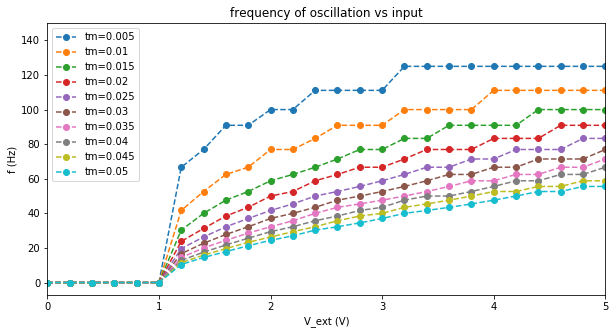

In [49]:

plt.figure(figsize=(10,5))
for j in range(10):
    plt.plot(V0_val, freq_val[:,j], 'o--')
    plt.xlim(0, 5)
plt.legend(['tm='+str(taum_val[i]) for i in range(10)])
plt.xlabel('V_ext (V)')
plt.ylabel('f (Hz)')
plt.title('frequency of oscillation vs input')

Observation: Frequency values are discrete

In [27]:
V_at_jump = np.argwhere(V0_val>1)[0,0]

Text(0.5, 1.0, 'Frequency jump vs tau_m')

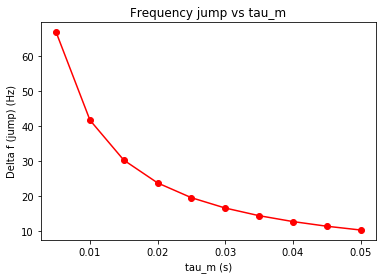

In [40]:
plt.plot(taum_val, freq_val[V_at_jump,:], 'ro-')
plt.xlabel('tau_m (s)')
plt.ylabel('Delta f (jump) (Hz)')
plt.title('Frequency jump vs tau_m')

# Obtain saturation frequency for different refractory periods

In [51]:
# effect of tau_m
dt = 1e-3
tref_val = dt*np.linspace(0, 50, 11)
V0_val = np.arange(0, 50, 0.2)
freq_val = np.zeros((len(V0_val),len(tref_val)))

T = 1000
tic = time.time()

for j in range(len(tref_val)):
    tref_j = tref_val[j]
    
    for i in range(len(V0_val)):
        V0 = V0_val[i]
        n = Neuron('n', t_ref=tref_j)
        net = Network('net')
        net.add_neuron(n)
        probe = net.initialize(probe=True, T_total=T)
        v_ext = V0*np.ones((1, T))
        for ti in range(T):
            net.update_state(dt, v_ext[:,ti].reshape((-1,1)), probe, ti)
        freq_val[i, j] = freq(probe['spike'][n.id, :], dt, get_avg=True)
print(f"time taken for {len(V0_val)*len(tref_val)} iterations: {time.time()-tic}s")

time taken for 2750 iterations: 82.46969389915466s


Text(0.5, 1.0, 'frequency of oscillation vs input for various t_ref')

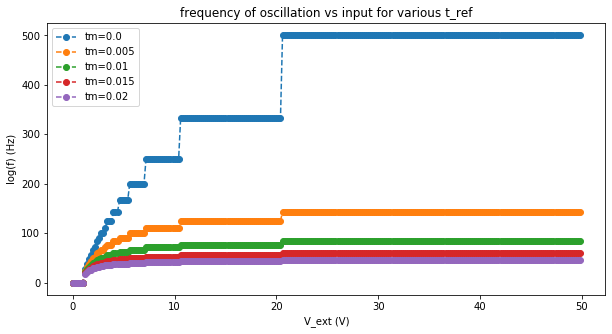

In [69]:
plt.figure(figsize=(10,5))
for j in range(5):
    plt.plot(V0_val, freq_val[:,j], 'o--')
#     plt.xlim(1, 1.5)
plt.legend(['tm='+str(tref_val[i]) for i in range(5)])
plt.xlabel('V_ext (V)')
plt.ylabel('log(f) (Hz)')
plt.title('frequency of oscillation vs input for various t_ref')

Text(0.5, 1.0, 'Saturation frequency vs refractory period')

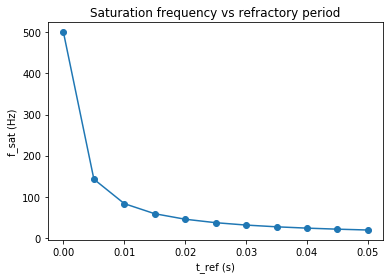

In [61]:
plt.plot(tref_val, freq_val[-1,:], 'o-')
plt.xlabel('t_ref (s)')
plt.ylabel('f_sat (Hz)')
plt.title("Saturation frequency vs refractory period")

# jump discontinuities in frequency: due to time resolution 

In [83]:
# effect of tau_m
# dt = 1e-3
dt_val = (1e-3)*np.linspace(0.1, 2, 20)
V0_val = np.arange(0, 20, 0.2)
freq_val = np.zeros((len(V0_val),len(dt_val)))

T = 1000
tic = time.time()

for j in range(len(dt_val)):
    dt = dt_val[j]
    for i in range(len(V0_val)):
        V0 = V0_val[i]
        n = Neuron('n')
        net = Network('net')
        net.add_neuron(n)
        probe = net.initialize(probe=True, T_total=T)
        v_ext = V0*np.ones((1, T))
        for ti in range(T):
            net.update_state(dt, v_ext[:,ti].reshape((-1,1)), probe, ti)
        freq_val[i, j] = freq(probe['spike'][n.id, :], dt, get_avg=True)
print(f"time taken for {len(V0_val)*len(dt_val)} iterations: {time.time()-tic}s")

time taken for 2000 iterations: 59.619075536727905s


Text(0, 0.5, 'f (Hz)')

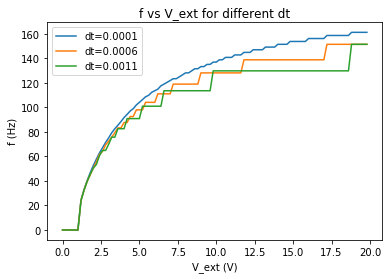

In [95]:
for i in range(3):
    plt.plot(V0_val, freq_val[:,5*i])
#     plt.xlim(5,10)
plt.legend(['dt='+str(round(dt_val[5*i], 4)) for i in range(3)])
plt.title('f vs V_ext for different dt')
plt.xlabel('V_ext (V)')
plt.ylabel('f (Hz)')